In [1]:
import os
import re
import _pickle as cPickle
import gc
import random
from tqdm import tqdm
import numpy as np
import torch

from datasets import load_dataset, load_metric
from evaluate import load
from rouge_metric import PyRouge


import math
from itertools import groupby

import wandb


DEVICES=['0',]
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(DEVICES)
# os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

cache_dir = "/data4/yoomcache"
model_cache_dir = os.path.join(cache_dir, 'huggingfaces')
data_cache_dir = os.path.join(cache_dir, 'datasets')
checkpoint_dir = os.path.join(cache_dir, 'checkpoint')

seed = 0
random.seed(0)
np.random.seed(seed)
torch.manual_seed(seed)

import IPython
import seaborn as sns
sns.set(rc = {'figure.figsize':(16,9)})

In [2]:
from wav2vec2GPTwCTC import *
from configuration_wav2vec2gpt import Wav2Vec2GPTConfig

from transformers import Wav2Vec2FeatureExtractor, GPT2Model
from transformers import GPT2Tokenizer, AddedToken
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [3]:
wav2vec_pretrained = "facebook/wav2vec2-base"
# wav2vec_pretrained = "facebook/wav2vec2-base-960h"
gpt_pretrained = "gpt2"

# Should aware that pad_token_id is used to compute CTC loss, 
# so pad_token configuration for both tokenizer and model should be the same
args = {
    
    'pad_token': "<|endoftext|>", 'pad_token_id': 50256,  # 'Ġ' ... 220,
    'unk_token': "<|endoftext|>", 'unk_token_id': 50256,
    'bos_token': "<|endoftext|>", 'bos_token_id': 50256,
    'eos_token': "<|endoftext|>", 'eos_token_id': 50256,
    'ctc_loss_reduction': 'mean',
    
    
    # Wav2Vec
    'hidden_dropout': 0.0,
    'activation_dropout': 0.0,
    'attention_dropout': 0.0,
    'feat_proj_dropout': 0.0,
    'feat_quantizer_dropout': 0.0,
    'final_dropout': 0.2,
    'layerdrop': 0.0,
    # GPT
    'resid_pdrop': 0.0,
    'embd_pdrop': 0.0,
    'attn_pdrop': 0.0,
    
    
    
    'select_random': True,
    'loss_ver': 'ctc',  # 'ctc-ce', 'ce-ctc', 'ctc', 'ce'
    
    
    'add_adapter': True,
    'num_adapter_layers': 4,
    'output_hidden_size': [128, 256, 256, 512],
    'adapter_kernel_size': [4, 3, 3, 3, 3], 
    'adapter_stride':      [2, 2, 2, 1, 1],
    'adapter_padding':     [4, 0, 0, 0, 0],
    'adapter_bias': False,
    
    
    'nhead': 4,
    'dim_feedforward': 1024,
    'topk_size': 48,
    'prev_window': 1, 
    'post_window': 1,
    
    
}

BATCH_SIZE = 16
LEARNING_RATE = 0.001

config = Wav2Vec2GPTConfig(**args)

In [4]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(wav2vec_pretrained, 
                                                             cache_dir=model_cache_dir,
                                                             **args)

tokenizer = GPT2Tokenizer.from_pretrained(gpt_pretrained,
                                          cache_dir=model_cache_dir,
                                          **args)

## Dataset

### Data Loading

In [5]:
data_dir = '/data4/TTS/'
data_fname = 'VCTK-Corpus/dataset-vctk-16k.pkl'
# data_fname = 'LibriTTS/train-clean-100.pkl'
# data_fname = 'LibriTTS/dev-clean.pkl'

dataset_ratio = 0.5
#########################################################

with open(os.path.join(data_dir, data_fname), 'rb') as f:
    gc.disable()
    dataset = cPickle.load(f)
    gc.enable()
print('entire dataset length: {}'.format(len(dataset['text'])))


dataset_size = int(len(dataset['text']) * dataset_ratio)
for k in dataset.keys():
    if k == 'sample_rate': continue
    del dataset[k][dataset_size:]
print('dataset length: {}'.format(dataset_size))


min_audio_length, max_audio_length = 1e6, 0
for arr in dataset['audio_array']:
    if len(arr) > max_audio_length:
        max_audio_length = len(arr)
    if len(arr) < min_audio_length:
        min_audio_length = len(arr)
print('maximum audio length: {} ({} sec)'.format(max_audio_length, 
                                                 max_audio_length / dataset['sample_rate']))
print('minimum audio length: {} ({} sec)'.format(min_audio_length, 
                                                 min_audio_length / dataset['sample_rate']))

entire dataset length: 44070
dataset length: 22035
maximum audio length: 308533 (19.2833125 sec)
minimum audio length: 13715 (0.8571875 sec)


### Data Example

In [6]:
idx = 11
print('text example: {}'.format(dataset['text'][idx]))
IPython.display.Audio(dataset['audio_array'][idx], rate=16000)

text example: People look, but no one ever finds it.


### Audio Preprocessing w/ `Wav2Vec2FeatureExtractor`

In [7]:
for idx in tqdm(range(dataset_size)):
    dataset['audio_array'][idx] = feature_extractor(dataset['audio_array'][idx], 
                                                    sampling_rate=dataset['sample_rate'],
                                                    return_tensors="pt",
                                                    padding='max_length',
                                                    max_length=max_audio_length,
                                                    ).input_values[0]

100%|████████████████████████████████████| 22035/22035 [00:53<00:00, 410.05it/s]


### Text Prepressing and Tokenizing w/ `GPT2Tokenizer`

In [8]:
_RE_REPLACE_PARENTHESIS = (r'[(){}_\[\]]', '')
_RE_REPLACE_QUESTIONMARK = ('\s\?', '?')
_RE_REPLACE_EXCLAMATIONMARK = ('\s\!', '!')
_RE_REPLACE_DOT = ('\s\.', '.')
_RE_COMBINE_WHITESPACE = (r'\s+', ' ')

re_list = [
    _RE_REPLACE_PARENTHESIS,
    _RE_COMBINE_WHITESPACE, 
    _RE_REPLACE_QUESTIONMARK,
    _RE_REPLACE_EXCLAMATIONMARK,
    _RE_REPLACE_DOT,
]

dataset['retext'] = list()

for txt in dataset['text']:
    retxt = txt
    retxt = retxt.lstrip(' .,?!')
    if retxt[:-1] in ['"', "'"]:
        retxt.strip('\"\'')    
    for pattern, repl in re_list:
        retxt = re.sub(pattern, repl, retxt).strip()
    
    dataset['retext'].append(retxt)
    

In [9]:
dataset['text'] = tokenizer(dataset['retext'],
                            return_tensors="pt",
                            padding='longest'  # VCTK: 42, libritts: 92
                            )

print(dataset['text']['attention_mask'].shape)

torch.Size([22035, 41])


### Generate Custom Dataset

In [10]:
split_ratio = (0.8, 0.9)
indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_idx = indices[:int(dataset_size * split_ratio[0])]
val_idx = indices[int(dataset_size * split_ratio[0]):int(dataset_size * split_ratio[1])]
test_idx = indices[int(dataset_size * split_ratio[1]):]

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_values, tokenized_output, indices):
        self.input_values = input_values
        self.tokenized_output = tokenized_output
        self.indices = indices

    def __getitem__(self, idx):
        item = dict()
        item['input_values'] = self.input_values[self.indices[idx]]
        item['labels'] = self.tokenized_output['input_ids'][self.indices[idx]]
        item['output_attention_mask'] = self.tokenized_output['attention_mask'][self.indices[idx]]
        return item

    def __len__(self):
        return len(self.indices)

    

train_dataset = CustomDataset(dataset['audio_array'], dataset['text'], train_idx)
val_dataset = CustomDataset(dataset['audio_array'], dataset['text'], val_idx)
# val_dataset = CustomDataset(dataset['audio_array'], dataset['text'], train_idx[:dataset_size // 10])
test_dataset = CustomDataset(dataset['audio_array'], dataset['text'], test_idx)

In [12]:
model = Wav2Vec2GPTModel(config=config)

model.wav2vec2 = Wav2Vec2Model2.from_pretrained(wav2vec_pretrained, cache_dir=model_cache_dir, config=config)
transformer = GPT2Model.from_pretrained(gpt_pretrained, cache_dir=model_cache_dir, config=config)
model.lm_head.weight = transformer.wte.weight
model.compressor.bias = nn.Parameter(transformer.wte.weight[config.pad_token_id])


model.freeze_feature_extractor()
# model.freeze_wav2vec_adapter()
# model.freeze_compressor()
model.freeze_lm_head()

if len(DEVICES) > 1:
    model = nn.DataParallel(model)

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2Model2: ['wav2vec2.encoder.layers.9.final_layer_norm.weight', 'wav2vec2.encoder.layers.6.attention.v_proj.weight', 'wav2vec2.encoder.layers.2.feed_forward.intermediate_dense.weight', 'wav2vec2.feature_projection.projection.weight', 'wav2vec2.encoder.layers.8.feed_forward.output_dense.weight', 'quantizer.codevectors', 'wav2vec2.encoder.layers.0.feed_forward.output_dense.weight', 'wav2vec2.encoder.layers.1.attention.q_proj.bias', 'wav2vec2.encoder.layers.0.feed_forward.output_dense.bias', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.feature_projection.layer_norm.weight', 'wav2vec2.encoder.layers.6.attention.q_proj.weight', 'wav2vec2.encoder.layers.6.feed_forward.intermediate_dense.weight', 'wav2vec2.encoder.layers.10.attention.q_proj.bias', 'wav2vec2.encoder.layers.5.feed_forward.intermediate_dense.bias', 'wav2vec2.encoder.layers.3.attention.out_proj.weight', 'wav2vec2.enc

Some weights of Wav2Vec2Model2 were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.adapter.layers.0.conv.weight', 'wav2vec2.adapter.layers.2.conv.weight', 'wav2vec2.adapter.layers.3.conv.weight', 'wav2vec2.adapter.layers.1.conv.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print(model)

Wav2Vec2GPTModel(
  (wav2vec2): Wav2Vec2Model2(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=Fal

In [14]:
###### load rouge for validation
# rouge = load_metric("rouge")  # pip install rouge
rouge = PyRouge()  # pip install rouge-metric
wer = load("wer")  # pip install jiwer

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions.argmax(axis=-1)
    
    ### only distinct ones
    pred_ids = [[key for key, _group in groupby(i)] for i in pred_ids]

    ### all unnecessary tokens are removed
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # rouge_output = rouge.compute(predictions=pred_str, references=label_str, 
    #                                rouge_types=["rouge2"])['rouge2'].mid
    wer_score = wer.compute(predictions=pred_str, references=label_str)
    rouge_score = rouge.evaluate(hypotheses=pred_str, 
                                 multi_references=[[ref] for ref in label_str])['rouge-2']
    
    return {
        "wer_score": round(wer_score, 4),
        # "rouge2_precision": round(rouge_output.precision, 4),
        # "rouge2_recall": round(rouge_output.recall, 4),
        # "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
        "rouge2_precision": round(rouge_score['p'], 4),
        "rouge2_recall": round(rouge_score['r'], 4),
        "rouge2_fmeasure": round(rouge_score['f'], 4),
    }

In [15]:
### set training arguments - these params are not really tuned, feel free to change ###

steps_per_epoch = math.ceil(len(train_dataset) / BATCH_SIZE / len(DEVICES))

training_args = Seq2SeqTrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE, 
    weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0,
    num_train_epochs=50,
    max_steps=-1,
    lr_scheduler_type="cosine", 
    
    logging_strategy='steps',
    logging_steps=(steps_per_epoch // 10),
    evaluation_strategy='steps',
    eval_steps=(steps_per_epoch),
    warmup_steps=(steps_per_epoch * 10),

    save_strategy='no',
    output_dir=os.path.join(checkpoint_dir, "wav2vec2gpt/freeze-adapter-rnn"),
    # save_steps=int(steps_per_epoch * 1),
    # save_total_limit=3,
    # overwrite_output_dir=True,
    
    eval_accumulation_steps=6,

)

In [16]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    # compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [17]:
##### start training #####
wandb.init(project="testing-wav2vec2gpt-221123", entity="yoom618") # 2f747faa5c3ba7aa67c3aa9a68f060bf273d26ba
torch.cuda.empty_cache()

trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yoom618. Use `wandb login --relogin` to force relogin


/home/yoomin/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17628
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 55100
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
1102,5.738300,15.674964
2204,4.596800,7.503765
3306,3.827300,4.310181
4408,3.232200,3.360904
5510,2.639900,2.892018
6612,2.200100,2.585675
7714,1.866500,2.336511
8816,1.641100,2.342409
9918,1.475400,2.225194
11020,1.369300,2.211391


***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2203
  Batch size = 16
***** 

TrainOutput(global_step=55100, training_loss=0.8934822290173027, metrics={'train_runtime': 30560.2924, 'train_samples_per_second': 28.841, 'train_steps_per_second': 1.803, 'total_flos': 8.12867721514767e+19, 'train_loss': 0.8934822290173027, 'epoch': 50.0})

In [18]:
wandb.finish()

eval/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▅█▆█▃▅▆▃▆▅▄▅▂▅▄▅▂▇▇▃▆▆▇▇▂▇▇▇▅▄▃▅▃▄▁▆▃▃▁▁
eval/samples_per_second,▃▁▃▁▆▃▂▆▂▃▄▃▆▃▄▃▆▂▁▆▃▂▂▂▆▂▂▂▃▅▅▄▆▄█▂▆▅▇█
eval/steps_per_second,▃▁▃▁▆▃▂▆▂▃▄▃▆▃▄▃▆▂▁▆▃▂▂▂▆▂▂▂▃▅▅▃▆▄█▂▆▅▇█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▅▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train/loss,█▇▅▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [19]:
# !ls /data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn

# model.load_state_dict(torch.load('/data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn/checkpoint-18000/pytorch_model.bin'))

In [20]:
##### train example


device = 'cuda:0'
batch_idx = train_idx

BATCH_SIZE = 16
i = 3

wer_, rouge_r, rouge_p, rouge_f = 0., 0., 0., 0.
for i in tqdm(range(len(train_idx)//BATCH_SIZE + 1)):
    
    batch_idx = train_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
    
    audio_feature_batch = list()
    for idx in batch_idx:
        audio_feature_batch.append(dataset['audio_array'][idx])
    audio_feature_batch = torch.stack(audio_feature_batch)

    label_batch = dataset['text']['input_ids'][batch_idx]
    attention_batch = dataset['text']['attention_mask'][batch_idx]

    with torch.no_grad():
        model.eval()
        pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
        pred_ids = pred_logits.argmax(dim=-1)

        ### only distinct ones
        pred_ids = [[key for key, _group in groupby(i)] for i in pred_ids]

        ### all unnecessary tokens are removed
        label_str = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
        pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

        # rouge_output = rouge.compute(predictions=pred_str, references=label_str, 
        #                                rouge_types=["rouge2"])['rouge2'].mid
        wer_score = wer.compute(predictions=pred_str, references=label_str)
        rouge_score = rouge.evaluate(hypotheses=pred_str, 
                                     multi_references=[[ref] for ref in label_str])['rouge-2']

        wer_ += wer_score * len(batch_idx)
        rouge_r += rouge_score['r'] * len(batch_idx)
        rouge_p += rouge_score['p'] * len(batch_idx)
        rouge_f += rouge_score['f'] * len(batch_idx)
        
print(wer_ / len(train_idx))
print(rouge_r / len(train_idx))
print(rouge_p / len(train_idx))
print(rouge_f / len(train_idx))

100%|███████████████████████████████████████| 1102/1102 [09:11<00:00,  2.00it/s]

0.014880120790940345
0.98379151737162
0.9879087703823104
0.9858270419561341


In [21]:
##### val example


device = 'cuda:0'
batch_idx = train_idx

BATCH_SIZE = 16
i = 3

wer_, rouge_r, rouge_p, rouge_f = 0., 0., 0., 0.
for i in tqdm(range(len(val_idx)//BATCH_SIZE + 1)):
    
    batch_idx = val_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
    
    audio_feature_batch = list()
    for idx in batch_idx:
        audio_feature_batch.append(dataset['audio_array'][idx])
    audio_feature_batch = torch.stack(audio_feature_batch)

    label_batch = dataset['text']['input_ids'][batch_idx]
    attention_batch = dataset['text']['attention_mask'][batch_idx]

    with torch.no_grad():
        model.eval()
        pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
        pred_ids = pred_logits.argmax(dim=-1)

        ### only distinct ones
        pred_ids = [[key for key, _group in groupby(i)] for i in pred_ids]

        ### all unnecessary tokens are removed
        label_str = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
        pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

        # rouge_output = rouge.compute(predictions=pred_str, references=label_str, 
        #                                rouge_types=["rouge2"])['rouge2'].mid
        wer_score = wer.compute(predictions=pred_str, references=label_str)
        rouge_score = rouge.evaluate(hypotheses=pred_str, 
                                     multi_references=[[ref] for ref in label_str])['rouge-2']

        wer_ += wer_score * len(batch_idx)
        rouge_r += rouge_score['r'] * len(batch_idx)
        rouge_p += rouge_score['p'] * len(batch_idx)
        rouge_f += rouge_score['f'] * len(batch_idx)
        
print(wer_ / len(val_idx))
print(rouge_r / len(val_idx))
print(rouge_p / len(val_idx))
print(rouge_f / len(val_idx))

100%|█████████████████████████████████████████| 138/138 [01:04<00:00,  2.13it/s]

0.40768008858889604
0.41386168227995934
0.42519038430105055
0.4192732778028717


In [24]:
##### example


BATCH_SIZE = 16
i = 3
device = 'cuda:0'
batch_idx = val_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]

audio_feature_batch = list()
for idx in batch_idx:
    audio_feature_batch.append(dataset['audio_array'][idx])
audio_feature_batch = torch.stack(audio_feature_batch)

label_batch = dataset['text']['input_ids'][batch_idx]
attention_batch = dataset['text']['attention_mask'][batch_idx]

with torch.no_grad():
    model.eval()
    pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
    pred_ids = pred_logits.argmax(dim=-1)
    
    for idx in range(BATCH_SIZE):
        print(len([key for key, _group in groupby(label_batch[idx])]))
        print(tokenizer.decode([key for key, _group in groupby(label_batch[idx])],skip_special_tokens=True))
        print()
        print(tokenizer.decode([key for key, _group in groupby(pred_ids[idx])],skip_special_tokens=True))
        print()
        print(tokenizer.decode(pred_ids[idx]))
        print()
        print()


5
Is that it?

Is that it?

<|endoftext|><|endoftext|><|endoftext|>Is that it<|endoftext|><|endoftext|>?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


9
those who are preparing to give up.

This her of pray give up them.

<|endoftext|><|endoftext|><|endoftext|>This<|endoftext|> her of pray<|endoftext|> give up them<|endoftext|>.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|

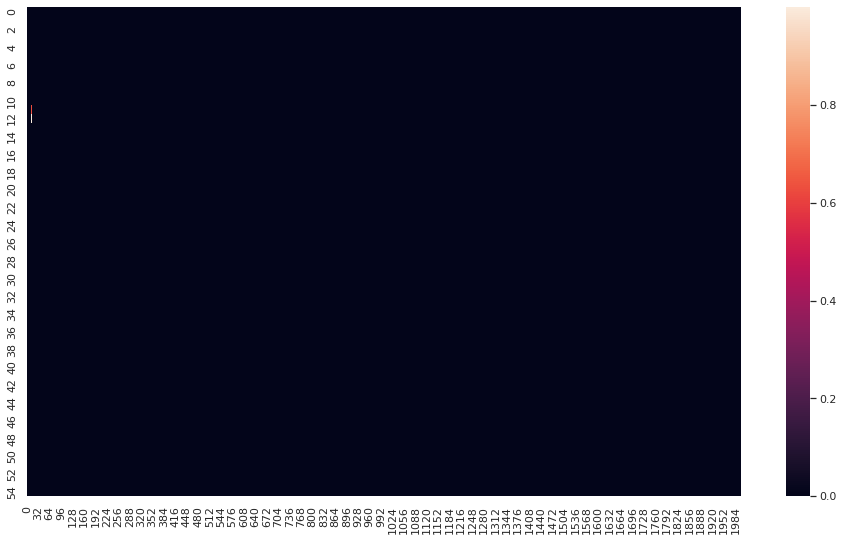

In [23]:
idx = 1

with torch.no_grad():
    model.eval()
    hidden_states_wav = model.wav2vec2(audio_feature_batch.to(device)).last_hidden_state
    hidden_states_wav = model.compressor(hidden_states_wav.transpose(1,2)).transpose(1,2)
    hidden_states_wav = model.attn(hidden_states_wav)
        
    sns.heatmap(
        nn.functional.softmax(model.lm_head(hidden_states_wav), dim=2).cpu()[idx,:55, :2000]
    )
    

IPython.display.Audio(dataset['audio_array'][batch_idx[idx]], rate=16000)